# Clasificación de señales de tráfico usando TensorFlow y Keras

Instalación de dependencias:

In [1]:
#!pip install tensorflow==2.10 opencv-python matplotlib

In [2]:
#!pip list

In [3]:
import tensorflow as t
import os

import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

# Importar dependencias para el modelo
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Importar dependencias para guardar el modelo
#from tensorflow.python.keras.models import save_model, load_model

In [4]:
gpus = t.config.experimental.list_physical_devices('GPU')
len(gpus) # 1 -> GPU disponible 

0

Funciones sobre imágenes:

In [5]:
data_dir = 'data'

# Mostrar una imagen con matplotlib usando cv2 para corregir los colores
def mostrarImagen(img: cv2.typing.MatLike):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

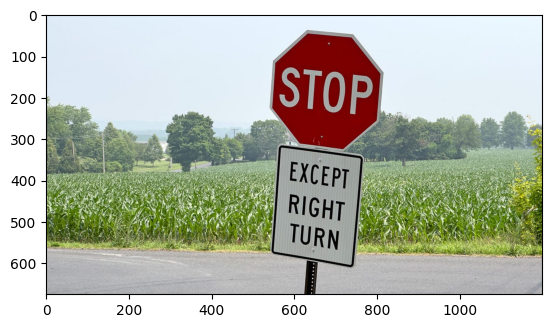

In [6]:
# Ejemplo de lectura de imagen
img = cv2.imread(os.path.join(data_dir, 'stop-sign', '1c56eb1de271aaca19a8f081dca6e5eb.jpg'))
mostrarImagen(img)

Carga de las imágenes:
  1. Eliminar imágenes que no tengan un formato comprendido entre los siguientes: JPEG, JPG, BMP, PNG.

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('La imágen no tiene el formato: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            pass

In [8]:
datos = t.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,  # Tamaño de lote de datos
)

Found 355 files belonging to 4 classes.


In [9]:
# Creamos un iterador para recorrer los datos
iterador_datos = datos.as_numpy_iterator()

In [10]:
lote_datos = iterador_datos.next() # Si tenemos error implica que las imágenes tienen formatos incorrectos.

In [11]:
lote_datos # (imagenes, etiquetas)

(array([[[[192.       , 206.       , 215.       ],
          [192.       , 206.       , 215.       ],
          [192.       , 206.       , 215.       ],
          ...,
          [199.18164  , 210.18164  , 216.18164  ],
          [200.6164   , 211.6164   , 217.6164   ],
          [198.84375  , 209.84375  , 215.84375  ]],
 
         [[192.       , 206.       , 215.       ],
          [192.       , 206.       , 215.       ],
          [192.       , 206.       , 215.       ],
          ...,
          [198.54492  , 209.54492  , 215.54492  ],
          [198.54492  , 209.54492  , 215.54492  ],
          [198.61603  , 209.61603  , 215.61603  ]],
 
         [[192.       , 206.       , 215.       ],
          [192.       , 206.       , 215.       ],
          [192.       , 206.       , 215.       ],
          ...,
          [197.9082   , 208.9082   , 214.9082   ],
          [196.42572  , 207.42572  , 213.42572  ],
          [198.15625  , 209.15625  , 215.15625  ]],
 
         ...,
 
         [[1

In [12]:
# Diccionario de etiquetas
nombre_etiqueta = {
    0: 'Señal Máx. 120Km/h',
    1: 'Señal Máx. 50Km/h',
    2: 'Señal Radar',
    3: 'Señal STOP'
}

def mostrarPrediccion(yhat: np.ndarray,img):

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Prediccion: {}'.format(nombre_etiqueta[np.argmax(yhat)]))
    plt.show()

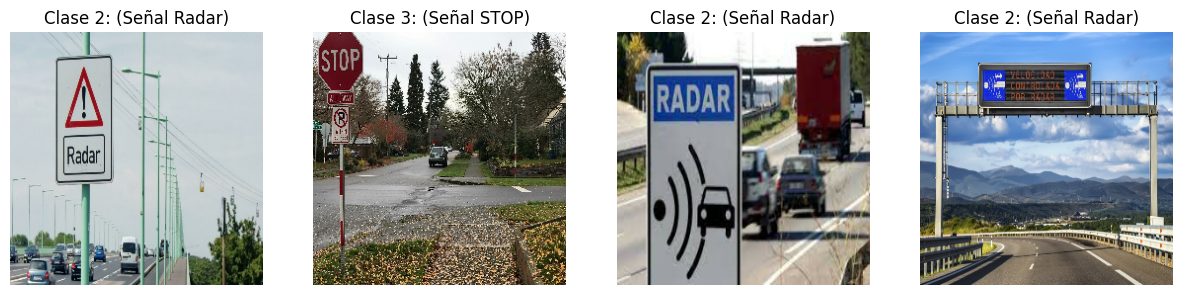

In [13]:
# Mostrar las clases de las imágenes con ejemplo
fig, axs = plt.subplots(1, 4, figsize=(15, 15),sharey=True)
for idx,img in enumerate(lote_datos[0][:4]):
    axs[idx].imshow(img.astype(np.uint8))
    clase = lote_datos[1][idx]
    axs[idx].set_title('Clase {}: ({})'.format(clase,nombre_etiqueta[clase]))
    axs[idx].axis('off')

Reescalado de las imágenes

In [14]:
datos = datos.map(lambda x,y: (x/255, y))

In [15]:
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next()

In [ ]:
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next()

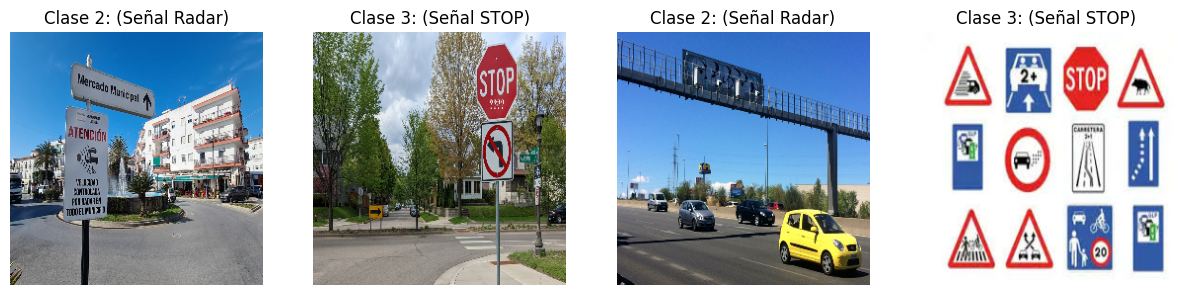

In [16]:
# Mostrar las clases de las imágenes con ejemplo
fig, axs = plt.subplots(1, 4, figsize=(15, 15),sharey=True)
for idx,img in enumerate(lote_datos[0][:4]):
    axs[idx].imshow(img)
    clase = lote_datos[1][idx]
    axs[idx].set_title('Clase {}: ({})'.format(clase,nombre_etiqueta[clase]))
    axs[idx].axis('off')

Definición de los conjuntos de imágenes para la creación del modelo:

In [17]:
size_entrenamiento = int(len(datos) * 0.7)
size_validacion = int(len(datos) * 0.15) + 1
size_test = int(len(datos) * 0.15) + 1

#len(datos) == size_entrenamiento + size_validacion + size_test

In [18]:
particion_entrenamiento = datos.take(size_entrenamiento)
particion_validacion = datos.skip(size_entrenamiento).take(size_validacion)
particion_test = datos.skip(size_entrenamiento + size_validacion)

Creación del modelo:

In [19]:
modelo  = Sequential() # Inicializar el modelo

In [20]:
modelo.add(Conv2D(16, (3, 3),1 , activation='relu', input_shape=(256, 256, 3))) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(32, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(16, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Flatten()) # Aplanar la imagen

modelo.add(Dense(256, activation='relu')) # Capa densa
modelo.add(Dense(4, activation='softmax')) # Capa densa

In [21]:
# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Ver las estadísticas del modelo generado
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

Fase de entrenamiento:

In [23]:
# Seleccionar directorio para guardar los logs
logs_dir = 'logs'
tensorboard_callback = t.keras.callbacks.TensorBoard(log_dir=logs_dir, histogram_freq=1)

In [24]:
# Entrenar el modelo y guardar los logs
hist = modelo.fit(particion_entrenamiento, validation_data=particion_validacion, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
8/8 [==============================] - 7s 718ms/step - loss: 1.5074 - accuracy: 0.2930 - val_loss: 1.3082 - val_accuracy: 0.2812
Epoch 2/20
8/8 [==============================] - 6s 679ms/step - loss: 1.2132 - accuracy: 0.3984 - val_loss: 1.0059 - val_accuracy: 0.6406
Epoch 3/20
8/8 [==============================] - 6s 679ms/step - loss: 0.9849 - accuracy: 0.6172 - val_loss: 0.8752 - val_accuracy: 0.6562
Epoch 4/20
8/8 [==============================] - 5s 613ms/step - loss: 0.7554 - accuracy: 0.7383 - val_loss: 0.6518 - val_accuracy: 0.7812
Epoch 5/20
8/8 [==============================] - 5s 585ms/step - loss: 0.6203 - accuracy: 0.8125 - val_loss: 0.4605 - val_accuracy: 0.7812
Epoch 6/20
8/8 [==============================] - 6s 676ms/step - loss: 0.4414 - accuracy: 0.8633 - val_loss: 0.2881 - val_accuracy: 0.9219
Epoch 7/20
8/8 [==============================] - 5s 618ms/step - loss: 0.2742 - accuracy: 0.9180 - val_loss: 0.2533 - val_accuracy: 0.9219
Epoch 8/20
8/8 [====

Rendimiento del modelo

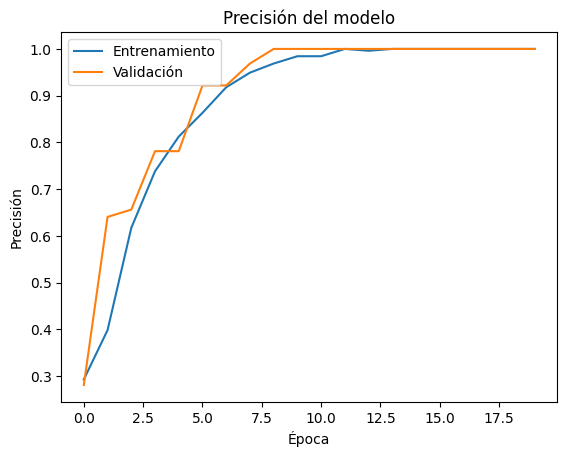

In [25]:
# Evaluar la precisión del modelo
fig = plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

Test Stop

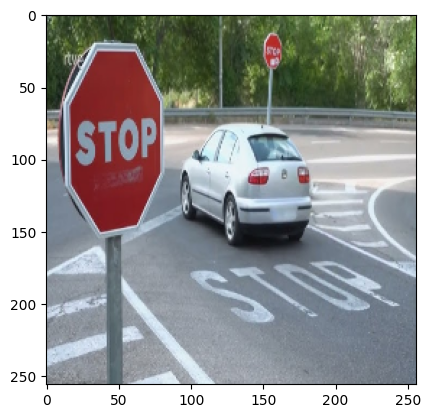

In [26]:
img = cv2.imread('test-stop.jpg')
resize = t.image.resize(img, [256, 256])
mostrarImagen(resize.numpy().astype(np.uint8))


In [27]:
yhat = modelo.predict(np.expand_dims(resize/255, axis=0))

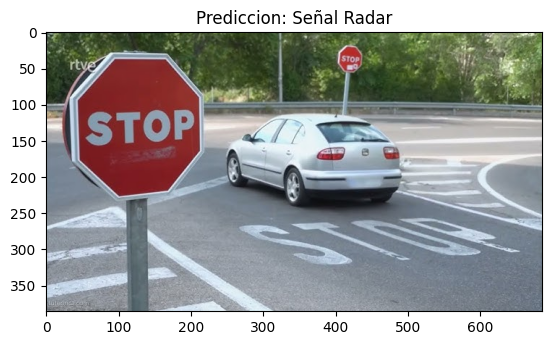

In [28]:
mostrarPrediccion(yhat,img)

Test 50Km/h

In [29]:
img = cv2.imread('test-50.jpg')
resize = t.image.resize(img, [256, 256])
#mostrarImagen(resize.numpy().astype(np.uint8))

In [30]:
yhat = modelo.predict(np.expand_dims(resize/255, axis=0))

In [31]:
yhat

array([[3.8368185e-06, 9.9996674e-01, 1.5349295e-05, 1.4080845e-05]],
      dtype=float32)

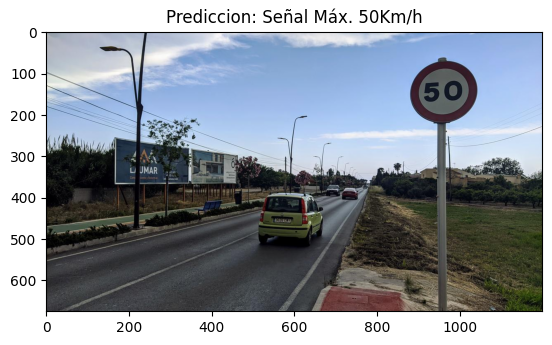

In [32]:
mostrarPrediccion(yhat,img)

Test Radar

In [33]:
img = cv2.imread('test-radar.jpeg')
resize = t.image.resize(img, [256, 256])

In [34]:
yhat = modelo.predict(np.expand_dims(resize/255, axis=0))

In [35]:
yhat

array([[3.6010236e-04, 2.8736724e-03, 9.9397498e-01, 2.7912522e-03]],
      dtype=float32)

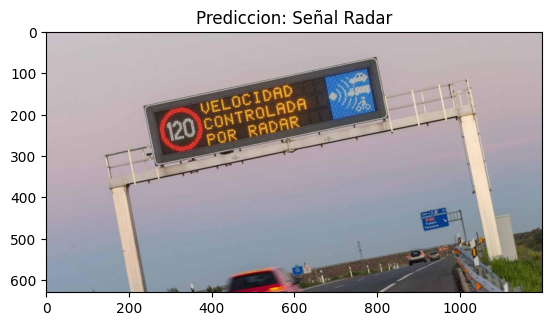

In [36]:
mostrarPrediccion(yhat,img)

Test 120km/h

In [37]:
img = cv2.imread('test-120.jpg')
resize = t.image.resize(img, [256, 256])

In [38]:
yhat = modelo.predict(np.expand_dims(resize/255, axis=0))

In [39]:
yhat

array([[6.7608547e-01, 3.3110358e-05, 3.2382867e-01, 5.2787826e-05]],
      dtype=float32)

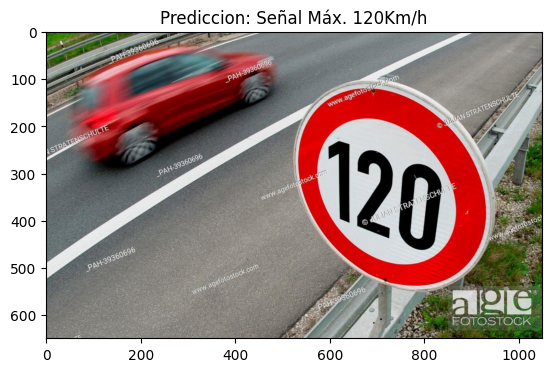

In [40]:
mostrarPrediccion(yhat,img)

Exportar el Modelo:

In [41]:
modelo.save(os.path.join('models','signclassifier.h5'))

In [42]:
modelo = t.keras.models.load_model(os.path.join('models','signclassifier.h5'))

img = cv2.imread('test-radar.jpeg')
resize = t.image.resize(img, [256, 256])

yhat = modelo(np.expand_dims(resize/255, axis=0))


In [43]:
yhat

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[3.6010236e-04, 2.8736724e-03, 9.9397498e-01, 2.7912522e-03]],
      dtype=float32)>

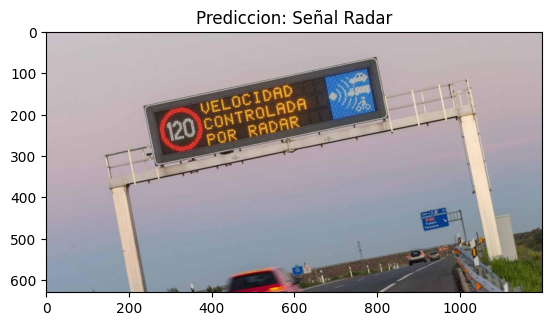

In [44]:
mostrarPrediccion(yhat,img)